In [21]:
from __future__ import annotations
from qiskit import Aer,execute
from scipy.optimize import minimize, maximize

In [5]:
import numpy as np
import networkx as nx

In [86]:
n_nodes = 10
adj_matrix = np.array([[0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
                      [0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
                      [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
                      [1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
                      [1, 1, 0, 1, 1, 0, 1, 0, 0, 1],
                      [0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                      [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
                      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
                      [1, 1, 0, 0, 0, 1, 0, 0, 0, 0]])

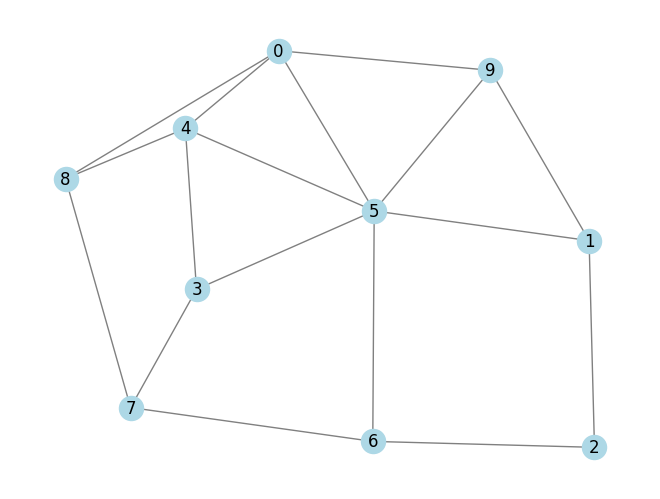

In [87]:
G = nx.from_numpy_array(adj_matrix)
layout = nx.random_layout(G, seed=10)
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')

In [109]:
from qiskit.circuit import QuantumCircuit, library
from qiskit.quantum_info import Pauli

def qaoa_circuit(n_nodes, adj_matrix, gamma, beta, print_circuit = False):
    qc = QuantumCircuit(n_nodes)

    parameters = [1,1] 
    p = len(parameters)
    assert p%2 == 0

    gamma = 1
    beta = 1
    #apply Hadamard for all gates: 
    for i in range(n_nodes):
        qc.h(i)

    # add the cost Hamiltonian 
    for n in range(int(p/2)):
        for j in range(n_nodes):
            for h in range(j):
                if adj_matrix[h,j] and h!=j:
                    qc.rzz(1*gamma, h, j)
        for j in range(n_nodes):
            if adj_matrix[j,j]:
                qc.rz(1*gamma, j)
    # add the mixer Hamiltonian
            qc.rx(1*beta, j)
    qc.measure_all()
    if print_circuit:
        print(qc)
    
    return qc

In [111]:
n_parameters = 3
betas = np.random.rand(n_parameters)
gammas = np.random.rand(n_parameters)
N_SHOTS = 100024
qc = qaoa_circuit(len(adj_matrix),adj_matrix, n_parameters, betas)
sim = Aer.get_backend('aer_simulator')
counts = sim.run(qc, seed_simulator = 100, nshots = N_SHOTS).result().get_counts()
counts

{'0101010111': 4,
 '0001100101': 3,
 '1011011011': 1,
 '1100000111': 4,
 '1100111011': 10,
 '1101010100': 1,
 '1101000011': 3,
 '0000000100': 3,
 '1000000110': 7,
 '1111111110': 4,
 '0111100010': 2,
 '1100010001': 1,
 '1110010001': 1,
 '0100000100': 2,
 '0001111111': 3,
 '1011010011': 1,
 '1100110011': 5,
 '1100001111': 3,
 '0010001001': 2,
 '1011110111': 4,
 '1100010111': 5,
 '1101000100': 1,
 '0000000011': 4,
 '1011110110': 1,
 '1100010110': 1,
 '0010001000': 6,
 '1111001111': 5,
 '1110010100': 1,
 '0001000110': 2,
 '0100000001': 6,
 '1101000111': 2,
 '0000000000': 15,
 '1000011001': 1,
 '1111111001': 12,
 '1101111110': 1,
 '1000111000': 1,
 '1000000101': 1,
 '1111111111': 18,
 '1000011111': 1,
 '1111001001': 9,
 '0100110000': 1,
 '0000010001': 2,
 '0101011111': 1,
 '1001100100': 1,
 '0001101101': 1,
 '0110101011': 1,
 '1111010111': 2,
 '1001011110': 1,
 '1000110111': 2,
 '1100111111': 3,
 '1011011111': 3,
 '1100000011': 6,
 '1010101000': 1,
 '0101111111': 1,
 '0111111001': 4,
 '0011

In [113]:
import sys 

def expectation_value(parameters, adj_matrix, p):
    n =0
    N_SHOTS = 1024

    qc = qaoa_circuit(len(adj_matrix),adj_matrix, parameters[0], parameters[1])
    sim = Aer.get_backend('aer_simulator')
    counts = sim.run(qc, seed_simulator=100, nshots=N_SHOTS).result().get_counts()
    
    strings = list(counts.keys())
    counts_of_counts= list(counts.values())
    Etot = 0

    def binary_vector(string):
        return np.array([int(bit) for bit in string])

    def E_value(solution, adj_matrix):
        cut_value = 0
        n = len(solution)  # Number of vertices

        for i in range(n):
            for j in range(i + 1, n):
                if solution[i] != solution[j]: 
                    cut_value += adj_matrix[i][j] 
        return -1*cut_value

    for i in range(len(strings)):
        if counts_of_counts[i]>1:
            E = E_value(binary_vector(strings[i]), adj_matrix)*counts_of_counts[i]/N_SHOTS
            Etot += E
    return Etot, counts

additional_results = None

def expectation_value_wrapper(parameters, adj_matrix, p):
    global additional_results
    scalar_value, additional_results = expectation_value(parameters, adj_matrix, p)
    return scalar_value

initial_parameters = np.random.rand(2)
print (initial_parameters)
#first_iteration = expectation_value(initial_parameters, adj_matrix, 2)
#print(first_iteration)
minimization = minimize(lambda x: expectation_value_wrapper(x, adj_matrix, 2),initial_parameters,method='Powell')
print(minimization)
sorted_dict = dict(sorted(additional_results.items(), key=lambda item: item[1], reverse=True))

print(sorted_dict)


[0.51846417 0.42719339]
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5.0302734375
       x: [ 5.185e-01  4.272e-01]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 7
{'1111111111': 18, '1111011111': 16, '0000000000': 15, '0000100000': 13, '1111111001': 12, '1001100110': 12, '1100111011': 10, '1111001001': 9, '1000100011': 9, '0110011001': 9, '0001000100': 8, '1011011110': 8, '0111000100': 8, '1111100111': 8, '1011101110': 8, '0000011000': 8, '1000000110': 7, '0111011100': 7, '1000000010': 7, '1000101010': 7, '1000111011': 7, '0010001000': 6, '0100000001': 6, '1100000011': 6, '0111111101': 6, '1000000001': 6, '0010000000': 6, '1001111111': 6, '0110011000': 6, '1001100001': 6, '1100110011': 5, '1100010111': 5, '1111001111': 5, '1110111001': 5, '1111111011': 5, '0111100000': 5, '0010101100': 5, '1110000010': 5, '1110001011': 5, '1110011001': 5, '1101110111': 5, '1111101110': 5, '0010000100': 5, '01000100

In [100]:
string = np.array([1,1,1,1,1])

def E_value(adj_matrix, solution):
    cut_value = 0
    n = len(solution)  # Number of vertices

    for i in range(n):
        for j in range(i + 1, n):
            if solution[i] != solution[j]: 
                cut_value += adj_matrix[i][j] 
    return cut_value

print(adj_matrix)
E_value(adj_matrix, string)

[[0 0 0 0 1 1 0 0 1 1]
 [0 0 1 0 0 1 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 1 0 0]
 [1 0 0 1 0 1 0 0 1 0]
 [1 1 0 1 1 0 1 0 0 1]
 [0 0 1 0 0 1 0 1 0 0]
 [0 0 0 1 0 0 1 0 1 0]
 [1 0 0 0 1 0 0 1 0 0]
 [1 1 0 0 0 1 0 0 0 0]]


0